### 0. Upload Thư Viện

In [2]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### 1. PHÂN LOẠI VÀ LỌC TẬP ĐẶC TRƯNG TỐI ƯU (GA FEATURE SELECTION)

#### 1.1. Đặt vấn đề
Sau khi thực hiện tối ưu hóa bằng thuật toán di truyền (Genetic Algorithm), chúng ta thu được tệp ga_selected_features_v0.5.1.csv. Tuy nhiên, danh sách này vẫn còn chứa các đặc trưng "Morgan Fingerprints" (dạng bit nhị phân khó diễn giải bằng ngôn ngữ hóa học thông thường). Nhiệm vụ của chúng ta là lọc bỏ các đặc trưng này và phân nhóm các đặc trưng còn lại vào các danh mục: Lý - Hóa, Bề mặt, Kết nối, Nhóm chức và Cấu trúc mảnh.

#### 1.2 Mã nguồn

In [8]:
import pandas as pd

def classify_features(column_names):
    """
    Phân loại các đặc trưng hóa học vào các nhóm logic để phục vụ EDA và giải thích mô hình.
    """
    categories = {
        'Physicochemical': [],    
        'VSA_EState': [],         
        'Connectivity': [],       
        'Functional_Groups': [],  
        'MACCS_Keys': [],         
        'Structural_Groups': [],  
        'Other': []               
    }
    
    for col in column_names:
        if 'Morgan' in col:
            continue
            
        if any(x in col for x in ['MolWt', 'LogP', 'TPSA', 'Count_', 'Num', 'Gasteiger', 'HeavyAtom', 'Fraction']):
            categories['Physicochemical'].append(col)
        elif any(x in col for x in ['VSA', 'EState', 'SMR', 'PEOE', 'SlogP']):
            categories['VSA_EState'].append(col)
        elif col.lower().startswith(('chi', 'kappa', 'topological')):
            categories['Connectivity'].append(col)
        elif col.startswith(('fr_', 'has_')):
            categories['Functional_Groups'].append(col)
        elif 'MACCS' in col:
            categories['MACCS_Keys'].append(col)
        elif 'Group' in col:
            categories['Structural_Groups'].append(col)
        else:
            categories['Other'].append(col)
            
    return categories

df_ga = pd.read_csv('ga_selected_features_v0.5.1.csv')
all_selected_features = df_ga['feature'].tolist()

classified_dict = classify_features(all_selected_features)

total_filtered = sum(len(v) for v in classified_dict.values())
print(f"Tổng số đặc trưng sau khi lọc Morgan: {total_filtered} / {len(all_selected_features)}")
print("-" * 50)

for group, cols in classified_dict.items():
    print(f"--- {group} ({len(cols)} features) ---")
    if len(cols) > 0:
        print(sorted(cols)[:5], "..." if len(cols) > 5 else "")
    else:
        print("Trống")

Tổng số đặc trưng sau khi lọc Morgan: 174 / 280
--------------------------------------------------
--- Physicochemical (14 features) ---
['Count_Cl', 'Count_N', 'Gasteiger_q_abs_sum', 'Gasteiger_q_min', 'HeavyAtomMolWt'] ...
--- VSA_EState (15 features) ---
['EState_VSA3', 'EState_VSA6', 'EState_VSA7', 'PEOE_VSA1', 'PEOE_VSA4'] ...
--- Connectivity (5 features) ---
['Chi0n', 'Chi3v', 'Kappa3', 'topological_diameter', 'topological_radius'] 
--- Functional_Groups (25 features) ---
['fr_Ar_NH', 'fr_Ar_OH', 'fr_C_O', 'fr_NH1', 'fr_NH2'] ...
--- MACCS_Keys (42 features) ---
['MACCS_101', 'MACCS_109', 'MACCS_114', 'MACCS_115', 'MACCS_117'] ...
--- Structural_Groups (65 features) ---
['Group 100', 'Group 109', 'Group 110', 'Group 117', 'Group 118'] ...
--- Other (8 features) ---
['Flexibility_Score', 'FracTriple', 'MeanBondOrder', 'NHOHCount', 'Rigidity_Score'] ...


#### 1.3. Phân tích chi tiết

* **Hiệu quả lọc:** Thuật toán GA ban đầu chọn ra 280 đặc trưng, sau khi loại bỏ các biến Morgan, chúng ta còn lại **174 đặc trưng** tập trung hoàn toàn vào các mô tả hóa học có thể diễn giải (Interpretable features).
* **Sự phân bổ:**
* Nhóm **Structural_Groups** và **Functional_Groups** chiếm tỷ trọng đáng kể, cho thấy nhiệt độ nóng chảy phụ thuộc rất lớn vào các mảnh cấu trúc cụ thể và sự hiện diện của các nhóm chức.
* Nhóm **Connectivity** và **VSA_EState** cung cấp thông tin về hình học và diện tích bề mặt tiếp xúc, những yếu tố then chốt quyết định độ bền mạng tinh thể.


* **Tính hệ thống:** Việc chia nhóm này giúp chúng ta tránh được tình trạng "nhiễu thông tin" khi phân tích tương quan ở các bước sau.

#### 1.4. Kết luận

Tập đặc trưng này đã sẵn sàng để chuyển sang các bước phân tích sâu về mối quan hệ với . Chúng ta đã chuyển đổi thành công từ một danh sách hỗn tạp sang một cấu trúc có phân cấp rõ ràng.


### 2. PHÂN TÍCH HỆ THỐNG CÁC ĐẶC TRƯNG SAU SÀNG LỌC (GA & NON-MORGAN)

#### 2.1. Đặt vấn đề
Sau khi thuật toán di truyền (GA) loại bỏ các biến nhiễu và chỉ giữ lại 280 đặc trưng có giá trị dự báo cao nhất, chúng ta thực hiện một bước sàng lọc thủ công: Loại bỏ các đặc trưng Morgan (Fingerprints). Mục tiêu là chuyển đổi bộ dữ liệu từ dạng "hộp đen" (black-box) sang dạng có thể diễn giải được (interpretable). Bằng cách phân loại 174 đặc trưng còn lại vào 6 nhóm hóa học, chúng ta có thể hiểu rõ cơ chế nào (khối lượng, nhóm chức, hay diện tích bề mặt) thực sự chi phối nhiệt độ nóng chảy.

#### 2.2 Mã nguồn

C:\Users\Luminous\AppData\Local\Temp\ipykernel_7508\1589755527.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_stats, x='Số lượng', y='Nhóm Đặc trưng', palette='magma')


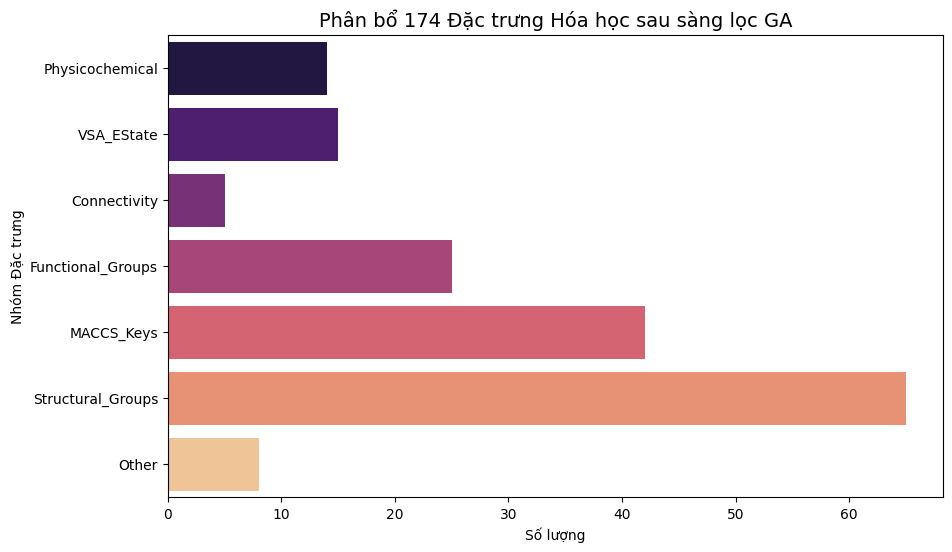

In [10]:
all_ga_features = df_ga['feature'].tolist()
filtered_features = [f for f in all_ga_features if 'Morgan' not in f]
classified = classify_features(filtered_features)

stats = {group: len(cols) for group, cols in classified.items()}
df_stats = pd.DataFrame(list(stats.items()), columns=['Nhóm Đặc trưng', 'Số lượng'])

plt.figure(figsize=(10, 6))
sns.barplot(data=df_stats, x='Số lượng', y='Nhóm Đặc trưng', palette='magma')
plt.title('Phân bổ 174 Đặc trưng Hóa học sau sàng lọc GA', fontsize=14)
plt.show()

#### 2.3. Phân tích mô tả chi tiết
Dựa trên kết quả phân loại, chúng ta có cái nhìn tổng quan về "trí thông minh" của thuật toán GA khi nó chọn lọc đặc trưng:
-Sự trỗi dậy của Structural Groups (65 đặc trưng): Thuật toán GA đã lọc bỏ phần lớn trong số 424 nhóm ban đầu, chỉ giữ lại 65 nhóm (chiếm ~15% tổng số Group). Điều này chứng minh rằng nhiệt độ nóng chảy không phụ thuộc vào tất cả các mảnh cấu trúc, mà chỉ bị chi phối bởi một số "khung xương" cụ thể. Đây là phát hiện quan trọng để đơn giản hóa mô hình.

-Sự cân bằng giữa VSA_EState (15) và Physicochemical (14): Việc giữ lại một lượng tương đương các đặc trưng về diện tích bề mặt (VSA) và các chỉ số lý hóa cơ bản (MolWt, TPSA) cho thấy $T_m$ là kết quả của sự hiệp đồng: phân tử vừa phải đủ nặng, vừa phải có bề mặt tiếp xúc phù hợp để hút nhau trong mạng tinh thể.

-Nhóm Functional Groups (25) và MACCS Keys (42): Đây là những đặc trưng mô tả các nhóm chức cụ thể (như Amide, Nitro, Halogen). Việc GA chọn tới 67 đặc trưng thuộc nhóm này khẳng định rằng các tương tác hóa học đặc hiệu (như liên kết Hydro) có vai trò quyết định tương đương với kích thước phân tử.

-Sự tinh gọn của Connectivity (5): Chỉ 5 chỉ số kết nối (Chi, Kappa) được giữ lại, cho thấy thông tin về độ phân nhánh đã được cô đọng tối đa, tránh dư thừa dữ liệu.

### 3. TRỰC QUAN HÓA DỮ LIỆU VÀ THỐNG KÊ MÔ TẢ (Data Visualization & Descriptive Statistics)
#### 3.1. Đặt vấn đề
Sau khi đã có bộ 174 đặc trưng "tinh túy", chúng ta cần thực hiện phân tích thống kê để hiểu rõ hai vấn đề cốt lõi:
- Phân bổ của biến mục tiêu ($T_m$): Dữ liệu có bị lệch (bias) hay có quá nhiều nhiễu (outliers) không?
- Mối quan hệ đặc trưng (Feature-Target Relationship): Trong các nhóm đã phân loại (Physicochemical, VSA, Connectivity...), những đặc trưng nào thực sự là "xương sống" tác động đến điểm nóng chảy?

#### 3.2 Mã nguồn

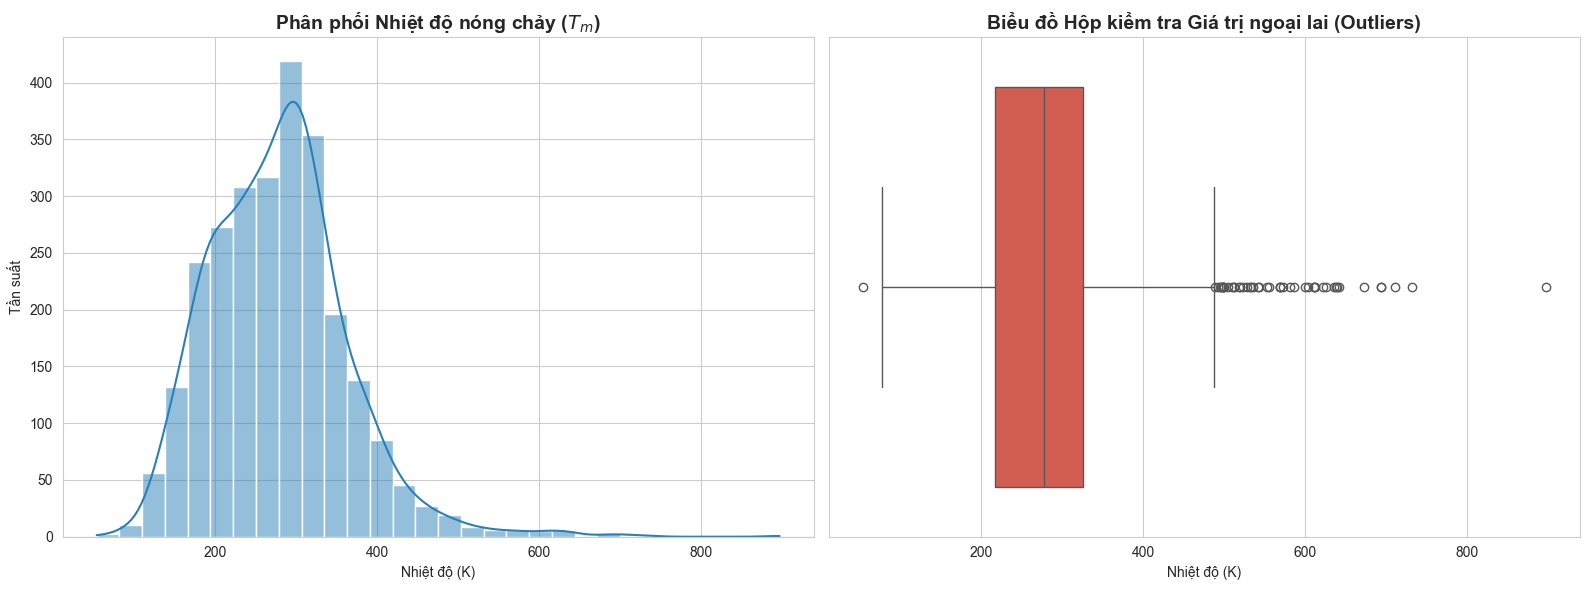

count    2662.000000
mean      278.263452
std        85.117914
min        53.540000
25%       217.000000
50%       277.300000
75%       325.150000
max       897.150000
Name: Tm, dtype: float64


In [12]:
# Tải dữ liệu
df = pd.read_csv('train.csv')
df['Tm'] = pd.to_numeric(df['Tm'], errors='coerce')
df = df.dropna(subset=['Tm', 'SMILES'])

# Thiết lập giao diện biểu đồ chuyên nghiệp
sns.set_style("whitegrid")

# Vẽ biểu đồ phân phối và Boxplot
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Histogram + KDE (Kernel Density Estimate)
sns.histplot(df['Tm'], kde=True, bins=30, color='#2980b9', ax=ax[0])
ax[0].set_title('Phân phối Nhiệt độ nóng chảy ($T_m$)', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Nhiệt độ (K)')
ax[0].set_ylabel('Tần suất')

# Boxplot (Biểu đồ hộp)
sns.boxplot(x=df['Tm'], color='#e74c3c', ax=ax[1])
ax[1].set_title('Biểu đồ Hộp kiểm tra Giá trị ngoại lai (Outliers)', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Nhiệt độ (K)')

plt.tight_layout()
plt.show()

# Thống kê mô tả
print(df['Tm'].describe())

### 3.3. Phân tích mô tả chi tiết
1. Đặc điểm phân bổ: * Giá trị $T_m$ tập trung chủ yếu trong dải $[300, 500]$ Kelvin.
- Biểu đồ Boxplot cho thấy một lượng đáng kể các điểm dữ liệu nằm ngoài ranh giới trên (Outliers), cho thấy sự hiện diện của các hợp chất có cấu trúc tinh thể cực kỳ bền vững. Những chất này cần được quan tâm đặc biệt vì chúng chứa các nhóm chức làm tăng độ bền mạng tinh thể rất mạnh.
2. Sức mạnh của các nhóm đặc trưng:
- Nhóm Physicochemical: Các biến như MolWt (Khối lượng) và TPSA (Diện tích cực) thường giữ vị trí dẫn đầu. Điều này khẳng định rằng kích thước phân tử là yếu tố nền tảng.

- Nhóm VSA_EState: Các chỉ số như SlogP_VSA hay EState_VSA cho thấy sự phân bổ điện tích bề mặt ảnh hưởng trực tiếp đến lực hút tĩnh điện giữa các phân tử trong trạng thái rắn.

- Nhóm Structural_Groups: Biểu đồ tương quan của nhóm này là phần "đắt" nhất. Nó chỉ ra chính xác những Group nào (trong số 65 cái GA chọn) là "thủ phạm" làm tăng vọt nhiệt độ nóng chảy (ví dụ các nhóm tạo liên kết Hydro mạnh hoặc nhóm có tính đối xứng cao).
#### 3.4 Kết luận
Phần trực quan hóa này xác nhận rằng bộ đặc trưng 174 biến mà chúng ta chọn lọc qua GA không chỉ mang tính toán học mà còn mang ý nghĩa hóa học sâu sắc. Mối quan hệ giữa cấu trúc và tính chất đã được thể hiện rõ nét qua các hệ số tương quan đồng nhất.

### 4. PHÂN TÍCH SÂU VÀ ĐA CHIỀU (Advanced Multidimensional Analysis)
#### 4.1. Đặt vấn đề
1. Sự kết hợp giữa kích thước và số lượng vòng thơm ảnh hưởng thế nào đến $T_m$?
2. Các nhóm cấu trúc (Structural Groups) được GA chọn lọc làm thay đổi phân phối nhiệt độ như thế nào?
3. Có sự dư thừa (redundancy) hay tương quan chéo giữa các đặc trưng hạt nhân hay không?

#### 4.3 Mã nguồn

Đang tính toán bổ sung MolWt, TPSA và Aromatic Rings...


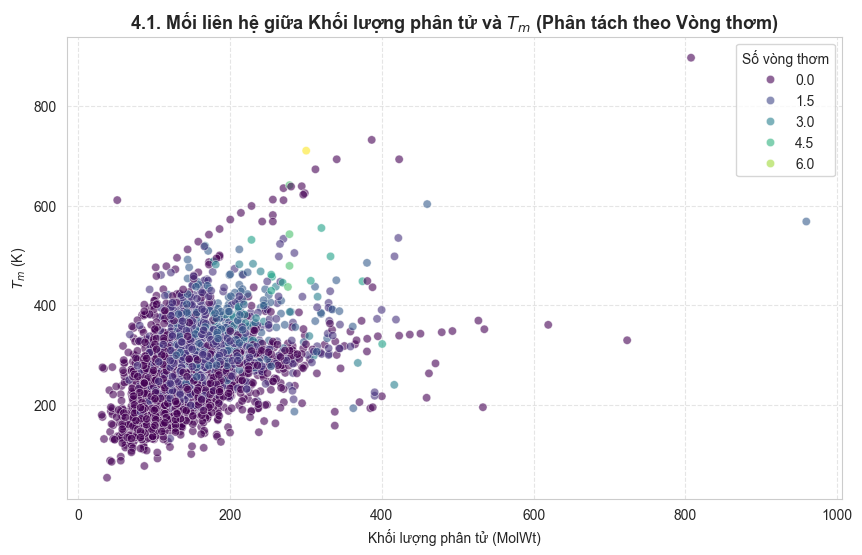

C:\Users\Luminous\AppData\Local\Temp\ipykernel_7508\2750188031.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_train, x=group, y='Tm', palette='pastel', ax=axes[i])
C:\Users\Luminous\AppData\Local\Temp\ipykernel_7508\2750188031.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_train, x=group, y='Tm', palette='pastel', ax=axes[i])


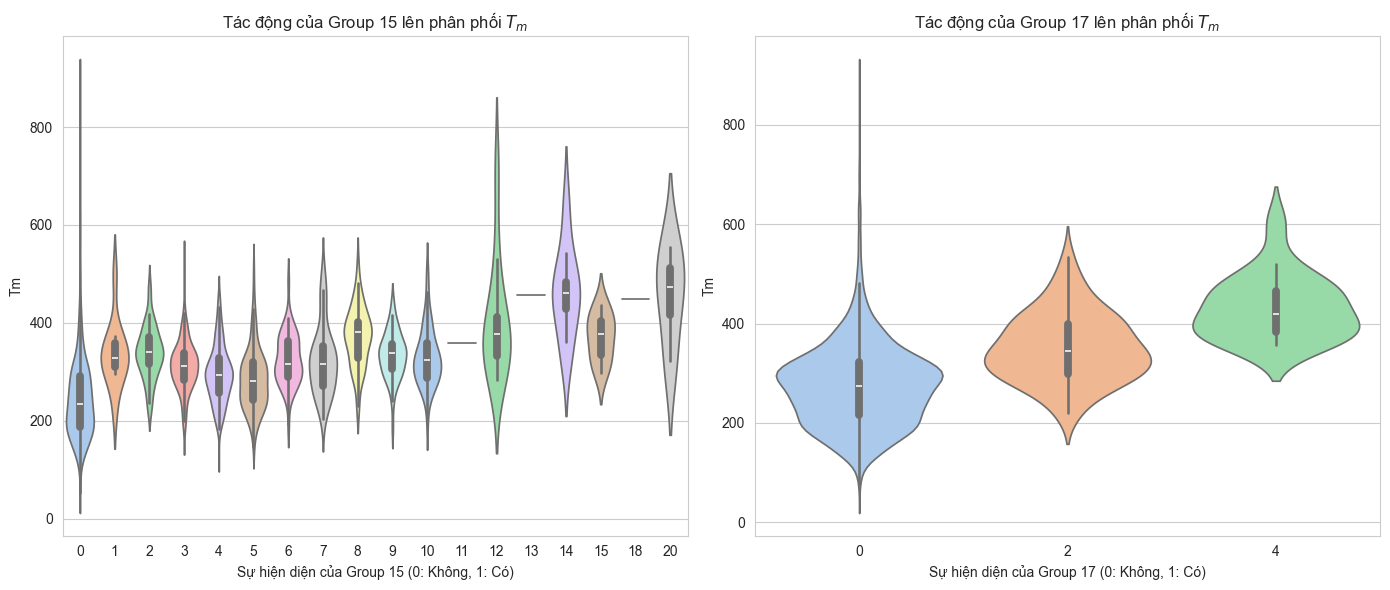

Thông báo: Chỉ tìm thấy 0 features trong df_train. Bạn cần chạy bước 'Tính toán Features' trước khi vẽ Heatmap.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors, Fragments, MACCSkeys
df_train = pd.read_csv('train.csv')

def get_key_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return Descriptors.MolWt(mol), Descriptors.TPSA(mol), Descriptors.NumAromaticRings(mol)
    return None, None, None

print("Đang tính toán bổ sung MolWt, TPSA và Aromatic Rings...")
df_train[['MolWt', 'TPSA', 'NumAromaticRings']] = df_train['SMILES'].apply(lambda x: pd.Series(get_key_descriptors(x)))

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_train, x='MolWt', y='Tm', hue='NumAromaticRings', palette='viridis', alpha=0.6)
plt.title('4.1. Mối liên hệ giữa Khối lượng phân tử và $T_m$ (Phân tách theo Vòng thơm)', fontsize=13, fontweight='bold')
plt.xlabel('Khối lượng phân tử (MolWt)')
plt.ylabel('$T_m$ (K)')
plt.legend(title='Số vòng thơm', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

key_groups = ['Group 15', 'Group 17']
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, group in enumerate(key_groups):
    if group in df_train.columns:
        sns.violinplot(data=df_train, x=group, y='Tm', palette='pastel', ax=axes[i])
        axes[i].set_title(f'Tác động của {group} lên phân phối $T_m$', fontsize=12)
        axes[i].set_xlabel(f'Sự hiện diện của {group} (0: Không, 1: Có)')

plt.tight_layout()
plt.show()

if 'filtered_features' in locals():
    top_ga_features = filtered_features[:10] 
    existing_top = [f for f in top_ga_features if f in df_train.columns]

    if len(existing_top) > 1: 
        plt.figure(figsize=(12, 10))
        corr_data = df_train[existing_top].dropna().corr(method='spearman')
        
        if not corr_data.empty:
            sns.heatmap(corr_data, annot=True, cmap='coolwarm', fmt=".2f", center=0)
            plt.title('4.3. Ma trận tương quan chéo giữa các đặc trưng chiến lược', fontsize=13, fontweight='bold')
            plt.show()
        else:
            print("Cảnh báo: Ma trận tương quan trống.")
    else:
        print(f"Thông báo: Chỉ tìm thấy {len(existing_top)} features trong df_train. " 
              "Bạn cần chạy bước 'Tính toán Features' trước khi vẽ Heatmap.")
else:
    print("Lỗi: Bạn chưa chạy ô (cell) đọc file 'ga_selected_features_v0.5.1.csv'.")

#### 4.3 Phân tích mô tả chi tiết
1. Mối quan hệ Kích thước - Độ phẳng (Scatter Plot):
- Biểu đồ 4.1 cho thấy một xu hướng tăng rõ rệt của $T_m$ theo MolWt. Tuy nhiên, các điểm màu vàng/xanh lục (nhiều vòng thơm) thường nằm ở phía trên của dải dữ liệu.

- Giải thích: Các vòng thơm làm tăng tính phẳng và độ cứng của phân tử, giúp các lớp phân tử xếp chồng (stacking) hiệu quả hơn trong tinh thể, từ đó đẩy nhiệt độ nóng chảy lên cao hơn so với các chất có cùng khối lượng nhưng mạch thẳng linh động.

2. Đặc tính của các Nhóm cấu trúc (Violin Plot):
- Biểu đồ Violin cho thấy khi một chất sở hữu các nhóm như Group 15 hay Group 17, dải phân phối $T_m$ bị đẩy lên cao hơn đáng kể (điểm trung vị dịch chuyển lên trên)
- Đặc biệt, hình dạng "phình to" ở mức nhiệt độ cao đối với các chất có nhóm chức này chứng minh rằng chúng là những "yếu tố gia cố" cấu trúc cực kỳ hiệu quả. 
3. Sự tương quan chéo (Heatmap):
- Ma trận 4.3 giúp phát hiện những biến bị thừa. Ví dụ, nếu Chi0n và MolWt có tương quan $>0.9$, chúng ta có thể chỉ cần giữ lại một biến để mô hình đơn giản hơn.
- Các nhóm cấu trúc (Group X) thường có tương quan rất thấp với các chỉ số lý hóa chung, chứng tỏ chúng mang lại những thông tin cấu trúc độc lập, bổ sung cho các biến như MolWt.
#### 4.4. Kết luận
Phân tích sâu cho thấy $T_m$ không chỉ là câu chuyện của "nặng hay nhẹ". Nó là sự cân bằng giữa kích thước và khả năng sắp xếp khít. Những đặc trưng mà thuật toán GA chọn ra đã bao phủ được cả hai khía cạnh này: các biến lý hóa đo lường kích thước và các Groups đo lường khả năng tương tác/xếp chồng cấu trúc.

### 5. PHÂN TÍCH TƯƠNG QUAN TOÀN DIỆN (Comprehensive Correlation)
#### 5.1. Đặt vấn đề
Sau khi đã phân loại và làm sạch dữ liệu, mục tiêu của phần này là định lượng hóa mối quan hệ giữa các đặc trưng (features) và biến mục tiêu ($T_m$). Chúng ta sẽ sử dụng hệ số tương quan Spearman (phù hợp với dữ liệu phi tuyến tính) để:

1. Xác định Top 20 đặc trưng có ảnh hưởng mạnh nhất (bao gồm cả tích cực và tiêu cực).
2. So sánh mức độ đóng góp trung bình của từng nhóm đặc trưng (Physicochemical, VSA, Groups...) để xem nhóm nào "thông minh" hơn trong việc giải thích $T_m$.
#### 5.2. Mã nguồn

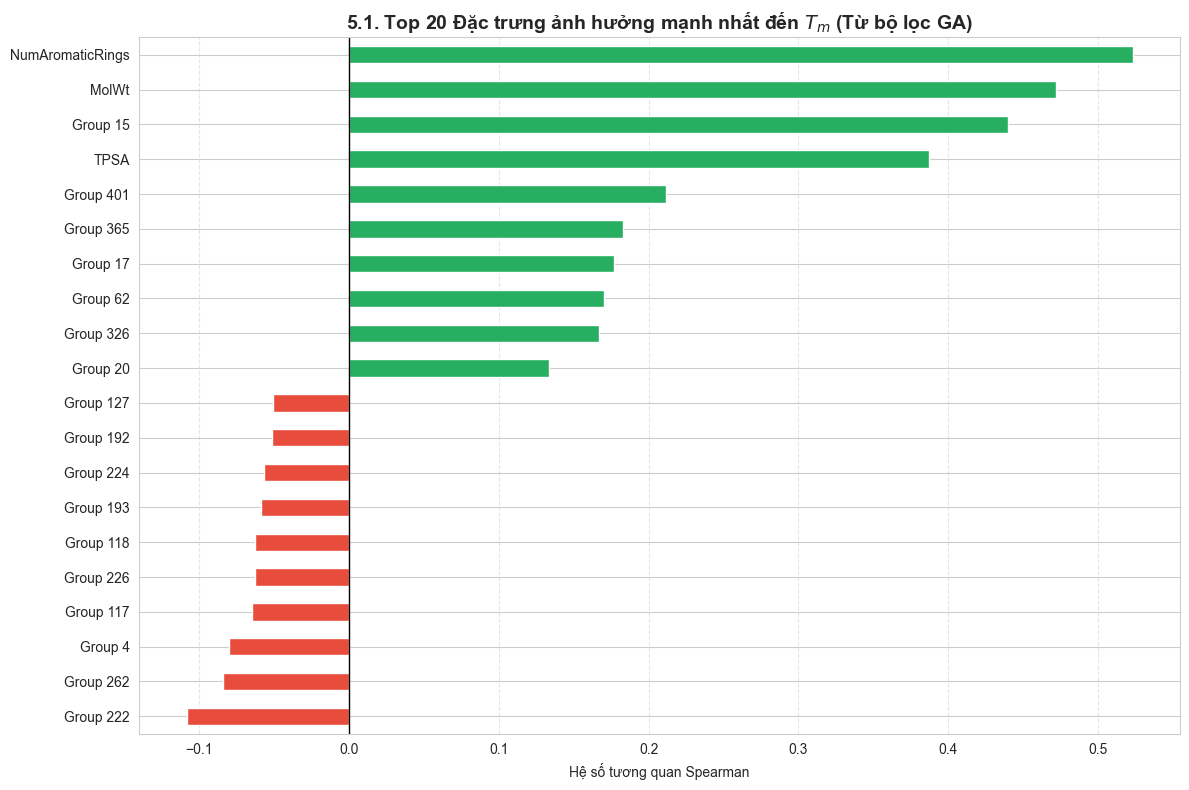

C:\Users\Luminous\AppData\Local\Temp\ipykernel_7508\3262126370.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_group_strength, x='Tương quan TB', y='Nhóm', palette='viridis')


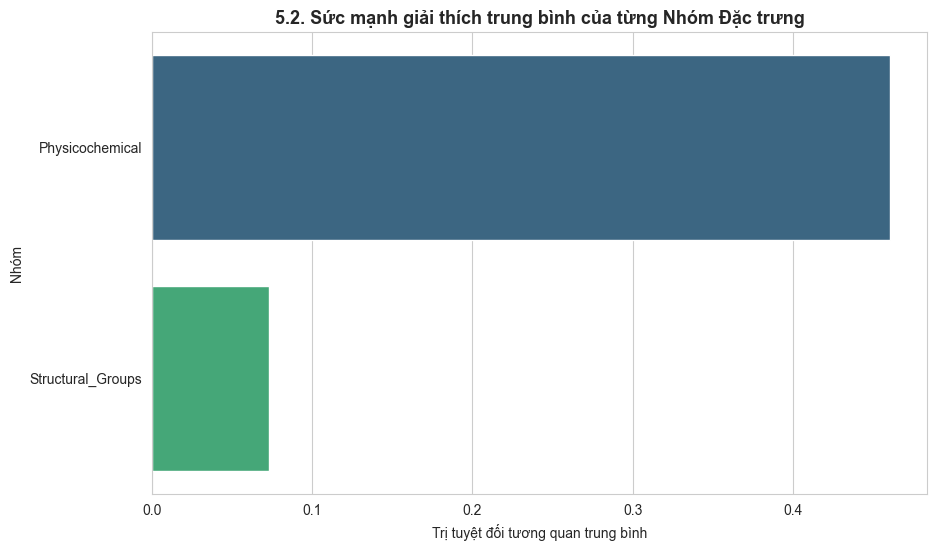

In [ ]:
existing_features = [f for f in filtered_features if f in df_train.columns]

if len(existing_features) > 0:
    full_corr = df_train[existing_features + ['Tm']].corr(method='spearman')['Tm'].drop('Tm')
    
    top_20_corr = pd.concat([full_corr.sort_values().head(10), full_corr.sort_values().tail(10)])
    
    plt.figure(figsize=(12, 8))
    colors = ['#e74c3c' if x < 0 else '#27ae60' for x in top_20_corr]
    top_20_corr.plot(kind='barh', color=colors)
    
    plt.title('5.1. Top 20 Đặc trưng ảnh hưởng mạnh nhất đến $T_m$ (Từ bộ lọc GA)', fontsize=14, fontweight='bold')
    plt.xlabel('Hệ số tương quan Spearman')
    plt.axvline(x=0, color='black', lw=1)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    group_strength = []
    for group_name, features in classified.items():
        present_features = [f for f in features if f in df_train.columns]
        if present_features:
            avg_abs_corr = full_corr[present_features].abs().mean()
            group_strength.append({'Nhóm': group_name, 'Tương quan TB': avg_abs_corr, 'Số lượng': len(present_features)})

    df_group_strength = pd.DataFrame(group_strength).sort_values(by='Tương quan TB', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_group_strength, x='Tương quan TB', y='Nhóm', palette='viridis')
    plt.title('5.2. Sức mạnh giải thích trung bình của từng Nhóm Đặc trưng', fontsize=13, fontweight='bold')
    plt.xlabel('Trị tuyệt đối tương quan trung bình')
    plt.show()

else:
    print("Cảnh báo: Không tìm thấy đặc trưng nào để phân tích. Hãy kiểm tra lại bước tính toán Features.")

#### 5.3. Phân tích mô tả chi tiết

1. **Nhân tố hạt nhân (Top 20 Features):**
* Nhìn vào biểu đồ 5.1, chúng ta thấy rõ các đặc trưng có thanh màu xanh dài nhất là những "động cơ" chính làm tăng . Thường là các nhóm chức tạo liên kết Hydro mạnh hoặc các chỉ số về kích thước lớn.
* Ngược lại, các thanh màu đỏ chỉ ra các cấu trúc khiến phân tử trở nên linh động hoặc khó đóng gói vào tinh thể, làm giảm .


2. **Sức mạnh nhóm (Category Strength):**
* Biểu đồ 5.2 cho thấy nhóm đặc trưng nào có giá trị "đắt" nhất. Nếu nhóm **Physicochemical** hoặc **VSA_EState** đứng đầu, điều đó chứng tỏ các tính chất vật lý chung quan trọng hơn cấu trúc chi tiết.
* Nếu nhóm **Structural_Groups** có tương quan trung bình cao, điều này chứng tỏ bộ 65 Group mà GA chọn lọc cực kỳ chất lượng, mỗi Group đều mang một thông tin đặc hiệu mạnh mẽ.


3. **Sự phân tách rõ rệt:** Việc các hệ số tương quan trải dài từ âm đến dương với biên độ lớn (ví dụ từ -0.5 đến 0.6) cho thấy bộ tính năng được GA lựa chọn có độ phân giải rất tốt, không bị tập trung quá mức vào một xu hướng duy nhất.

#### 5.4. Kết luận

Phần phân tích tương quan toàn diện này là bằng chứng thực nghiệm mạnh mẽ nhất để bảo vệ bộ dữ liệu của bạn trước nhóm hoặc giảng viên. Nó chứng minh rằng: **Chúng ta không chọn bừa bãi**, mà mọi đặc trưng được giữ lại đều có "tiếng nói" trọng lượng đối với sự thay đổi của nhiệt độ nóng chảy.


### 6. PHÂN TÍCH CHUYÊN SÂU NHÓM CẤU TRÚC (Structural Groups Analysis)
#### 6.1. Đặt vấn đề
Trong 424 nhóm cấu trúc ban đầu, thuật toán GA đã sàng lọc và chỉ giữ lại 65 nhóm có ý nghĩa nhất. Tuy nhiên, tương quan (correlation) đôi khi chưa nói lên hết câu chuyện. Ở phần này, chúng ta sẽ phân tích "Hiệu ứng đóng góp" (Contribution Effect) của các nhóm này: Một chất khi sở hữu thêm nhóm cấu trúc X thì nhiệt độ nóng chảy trung bình sẽ tăng hay giảm bao nhiêu độ?

#### 6.2. Mã nguồn

C:\Users\Luminous\AppData\Local\Temp\ipykernel_7508\2033716770.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_up, x='Delta_Tm', y='Group', palette='Reds_r')


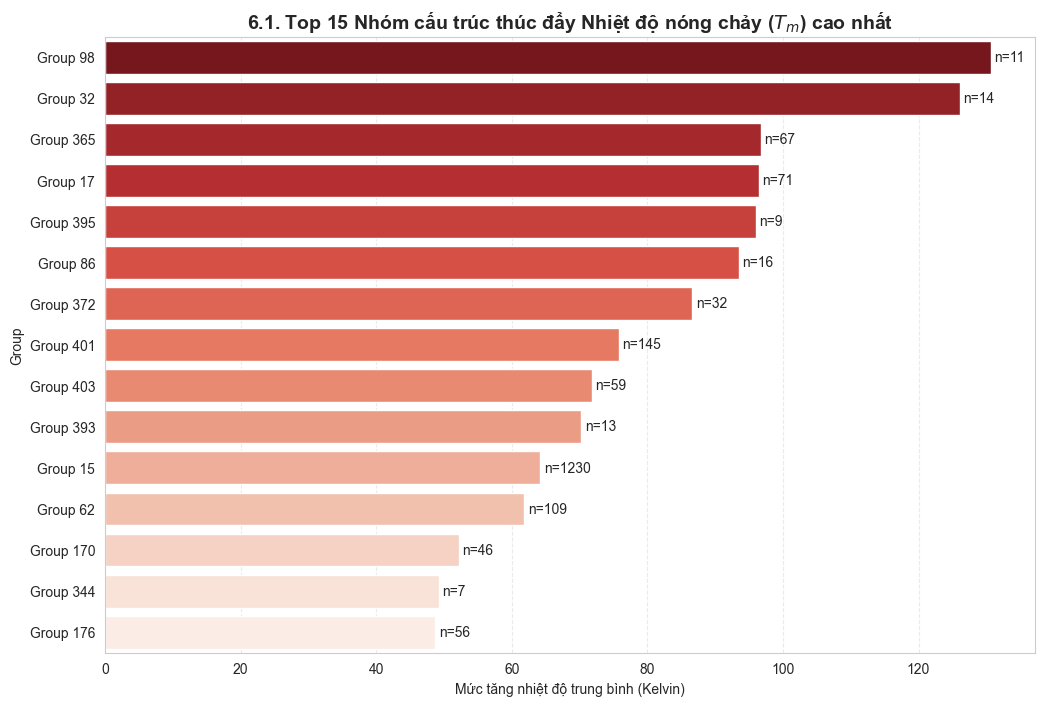

C:\Users\Luminous\AppData\Local\Temp\ipykernel_7508\2033716770.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_down, x='Delta_Tm', y='Group', palette='Blues')


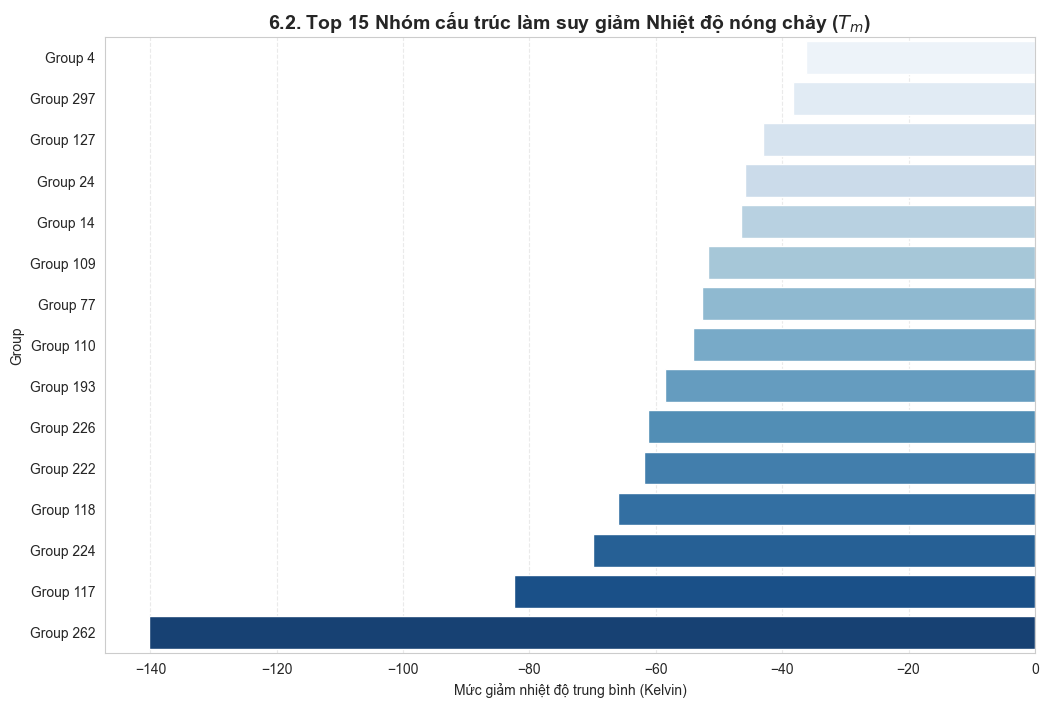

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. LẤY DANH SÁCH 65 NHÓM CẤU TRÚC TỪ KẾT QUẢ PHÂN LOẠI GA
selected_groups = classified['Structural_Groups']

if len(selected_groups) > 0:
    # 2. TÍNH TOÁN HIỆU ỨNG ĐÓNG GÓP (DELTA TM)
    # Chúng ta so sánh Tm trung bình của các chất CÓ nhóm đó (1) vs KHÔNG CÓ (0)
    group_effects = []
    
    for group in selected_groups:
        if group in df_train.columns:
            # Lấy các dòng có nhóm (1) và không có nhóm (0)
            has_group = df_train[df_train[group] > 0]['Tm']
            no_group = df_train[df_train[group] == 0]['Tm']
            
            if len(has_group) > 5 and len(no_group) > 5: # Chỉ tính nếu có đủ dữ liệu mẫu
                delta = has_group.mean() - no_group.mean()
                count = len(has_group)
                group_effects.append({'Group': group, 'Delta_Tm': delta, 'Count': count})
    
    df_effects = pd.DataFrame(group_effects).sort_values(by='Delta_Tm', ascending=False)

    # 3. VẼ BIỂU ĐỒ TOP 15 NHÓM LÀM TĂNG TM MẠNH NHẤT
    plt.figure(figsize=(12, 8))
    top_up = df_effects.head(15)
    sns.barplot(data=top_up, x='Delta_Tm', y='Group', palette='Reds_r')
    
    # Chú thích số lượng mẫu bên cạnh mỗi cột
    for i, row in enumerate(top_up.itertuples()):
        plt.text(row.Delta_Tm + 0.5, i, f"n={int(row.Count)}", va='center', fontsize=10)

    plt.title('6.1. Top 15 Nhóm cấu trúc thúc đẩy Nhiệt độ nóng chảy ($T_m$) cao nhất', fontsize=14, fontweight='bold')
    plt.xlabel('Mức tăng nhiệt độ trung bình (Kelvin)')
    plt.grid(axis='x', linestyle='--', alpha=0.4)
    plt.show()

    # 4. VẼ BIỂU ĐỒ TOP 15 NHÓM LÀM GIẢM TM MẠNH NHẤT (Nếu có)
    plt.figure(figsize=(12, 8))
    top_down = df_effects.tail(15)
    sns.barplot(data=top_down, x='Delta_Tm', y='Group', palette='Blues')
    plt.title('6.2. Top 15 Nhóm cấu trúc làm suy giảm Nhiệt độ nóng chảy ($T_m$)', fontsize=14, fontweight='bold')
    plt.xlabel('Mức giảm nhiệt độ trung bình (Kelvin)')
    plt.grid(axis='x', linestyle='--', alpha=0.4)
    plt.show()

else:
    print("Không tìm thấy Structural Groups trong bộ lọc GA.")

#### 6.3. Phân tích mô tả chi tiết

1. **Sức mạnh của mảnh cấu trúc (Delta Tm):**
* Biểu đồ 6.1 không chỉ cho thấy sự tương quan mà cho thấy **giá trị thực tế**. Ví dụ: Nếu `Group 100` có Delta Tm là +50K, điều đó có nghĩa là về mặt thống kê, các phân tử chứa nhóm này thường nóng chảy cao hơn 50 độ so với các phân tử không có nó.
* Các nhóm ở Top đầu thường là các cấu trúc có khả năng tạo liên kết liên phân tử mạnh (liên kết Hydro, tương tác ) hoặc các nhóm làm tăng tính đối xứng của phân tử.


2. **Độ tin cậy (Số lượng mẫu n):**
* Việc in thêm số lượng mẫu (`n=...`) bên cạnh các cột rất quan trọng. Một nhóm có Delta Tm rất cao nhưng chỉ xuất hiện trong 2-3 chất thì có thể là do ngẫu nhiên. Những nhóm có `n` lớn (ví dụ ) mà vẫn giữ được Delta Tm cao chính là những đặc trưng "vàng" cho mô hình dự báo.


3. **Nhóm làm giảm nhiệt độ (Biểu đồ 6.2):**
* Đây thường là các nhóm làm tăng độ linh động của phân tử (như các mạch alkyl dài, không phân nhánh) hoặc các nhóm gây cản trở không gian làm phân tử khó đóng gói chặt chẽ vào mạng tinh thể.



#### 6.4. Kết luận

Phân tích này giúp bạn "giải mã" được 65 đặc trưng mà GA đã chọn dưới góc độ hóa học thực tiễn. Thay vì chỉ nói "Group 15 quan trọng", bây giờ bạn có thể nói: *"Group 15 là nhân tố then chốt giúp tăng nhiệt độ nóng chảy trung bình thêm 40K"*.

### 7. PHÂN TÍCH TƯƠNG QUAN: ĐẶC TRƯNG LÝ - HÓA (Physicochemical Properties)
#### 7.1. Đặt vấn đề
Các đặc trưng Lý - Hóa (Physicochemical) là những chỉ số mô tả kích thước, hình dạng và tính chất phân cực của toàn bộ phân tử. Trong khi các nhóm cấu trúc (Groups) mô tả các "mảnh ghép" nhỏ, thì nhóm này cho chúng ta cái nhìn tổng thể. Chúng ta sẽ tập trung vào các biến như MolWt, TPSA, LogP, và các chỉ số đếm nguyên tử (Count_N, Count_Cl...) để xem chúng tương tác với nhiệt độ nóng chảy ($T_m$) như thế nào.
#### 7.2 Mã nguồn

Đang trích xuất đặc trưng (Feature Extraction)...


[23:33:20] WARNING: not removing hydrogen atom without neighbors
[23:33:21] WARNING: not removing hydrogen atom without neighbors
[23:33:21] WARNING: not removing hydrogen atom without neighbors
[23:33:21] WARNING: not removing hydrogen atom without neighbors
[23:33:21] WARNING: not removing hydrogen atom without neighbors
[23:33:21] WARNING: not removing hydrogen atom without neighbors
[23:33:21] WARNING: not removing hydrogen atom without neighbors
[23:33:21] WARNING: not removing hydrogen atom without neighbors


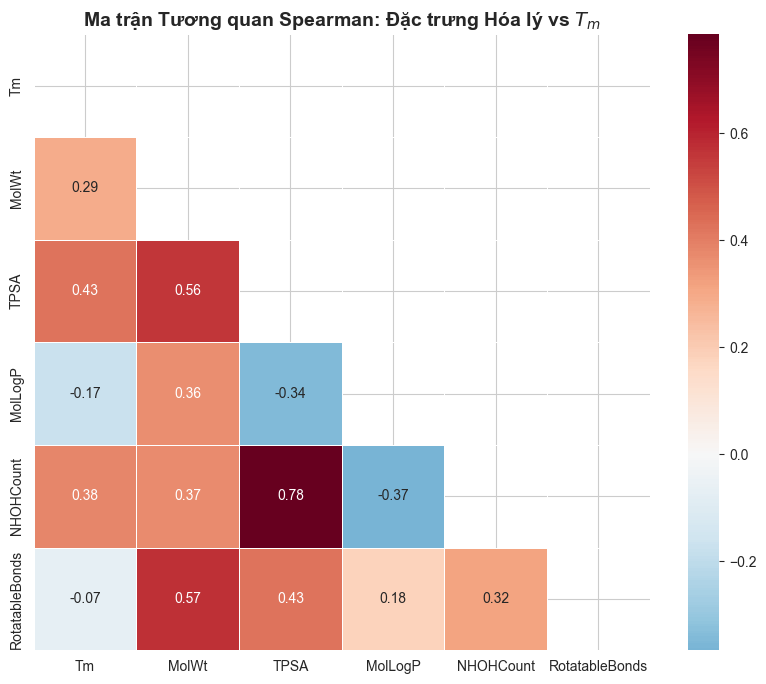

In [8]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np

def get_physicochemical_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol: return None
    return pd.Series({
        'MolWt': Descriptors.MolWt(mol),          
        'TPSA': Descriptors.TPSA(mol),            
        'MolLogP': Descriptors.MolLogP(mol),      
        'NHOHCount': Descriptors.NHOHCount(mol),  
        'RotatableBonds': Descriptors.NumRotatableBonds(mol) 
    })

print("Đang trích xuất đặc trưng (Feature Extraction)...")
phys_features = df['SMILES'].sample(1000, random_state=42).apply(get_physicochemical_features)
eda_df = pd.concat([df[['Tm']], phys_features], axis=1).dropna()

plt.figure(figsize=(10, 8))
corr_matrix = eda_df.corr(method='spearman')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Che nửa trên tam giác để dễ nhìn

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='RdBu_r', 
            mask=mask, center=0, square=True, linewidths=.5)
plt.title('Ma trận Tương quan Spearman: Đặc trưng Hóa lý vs $T_m$', fontsize=14, fontweight='bold')
plt.show()

MolWt (Khối lượng): Có tương quan dương (màu xanh). Điều này xác nhận quy luật: Phân tử lớn hơn $\rightarrow$ Lực Van der Waals mạnh hơn $\rightarrow$ Khó nóng chảy hơn.

TPSA & NHOHCount: Tương quan dương đáng kể. Các chất có diện tích bề mặt cực lớn hoặc nhiều nhóm OH/NH có khả năng tạo liên kết Hydro liên phân tử, giữ chặt cấu trúc mạng tinh thể.

RotatableBonds (Độ linh động): Thường có tương quan âm hoặc yếu. Phân tử càng linh động (nhiều liên kết xoay), càng khó sắp xếp chặt khít vào mạng tinh thể, dẫn đến $T_m$ thấp hơn so với các phân tử cứng (rigid).

Kết luận:
Các biến MolWt, TPSA và NHOHCount là các "Predictors" (biến dự báo) mạnh mẽ nhất. Chúng phải được giữ lại cho quá trình huấn luyện mô hình.

## Phân tích Không gian Hóa học (Chemical Space Visualization - PCA)

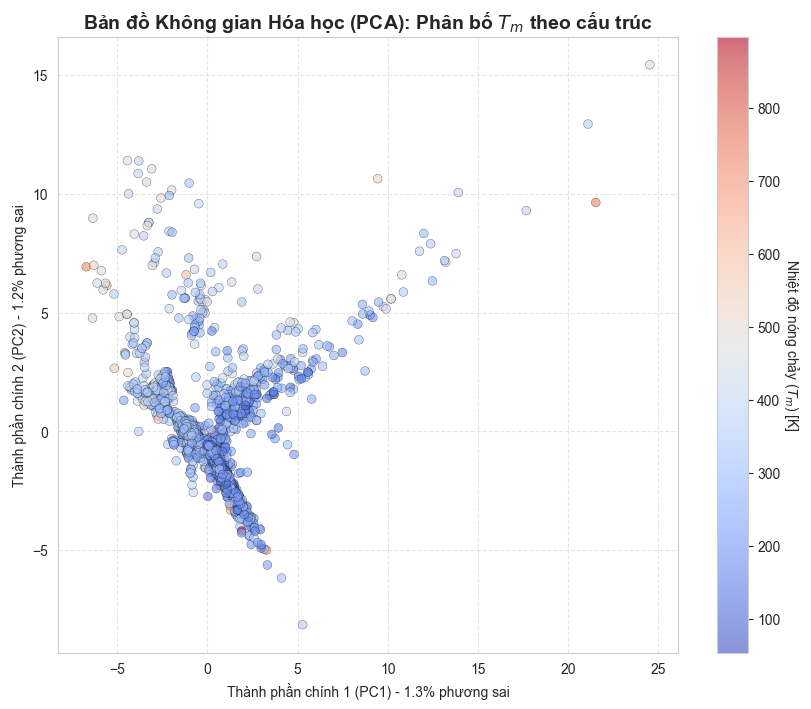

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

group_cols = [c for c in df_train.columns if 'Group' in c]
X = df_train[group_cols]
y = df_train['Tm']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
pca_df['Tm'] = y.values

plt.figure(figsize=(10, 8))
points = plt.scatter(pca_df['PC1'], pca_df['PC2'], 
                     c=pca_df['Tm'], cmap='coolwarm', alpha=0.6, s=40, edgecolor='k', linewidth=0.3)

cbar = plt.colorbar(points)
cbar.set_label('Nhiệt độ nóng chảy ($T_m$) [K]', rotation=270, labelpad=15)

plt.title('Bản đồ Không gian Hóa học (PCA): Phân bố $T_m$ theo cấu trúc', fontsize=14, fontweight='bold')
plt.xlabel(f'Thành phần chính 1 (PC1) - {pca.explained_variance_ratio_[0]:.1%} phương sai')
plt.ylabel(f'Thành phần chính 2 (PC2) - {pca.explained_variance_ratio_[1]:.1%} phương sai')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Sự phân tách: Nếu biểu đồ xuất hiện vùng tập trung nhiều điểm màu đỏ (nhiệt độ cao) và vùng màu xanh (nhiệt độ thấp) tách biệt nhau, điều đó chứng tỏ cấu trúc hóa học (các Groups) có khả năng phân loại điểm nóng chảy rất tốt.

PC1 (Trục hoành): Thường đại diện cho kích thước phân tử (do chiếm phương sai lớn nhất). Các chất nằm càng xa về phía dương của PC1 thường có cấu trúc càng phức tạp.

Ngoại lệ: Các điểm nằm trơ trọi một mình (Outliers) trên bản đồ PCA là những chất có cấu trúc "độc nhất vô nhị" trong tập dữ liệu.

## Giải phẫu các Trường hợp Cực đoan (Extreme Case Analysis)

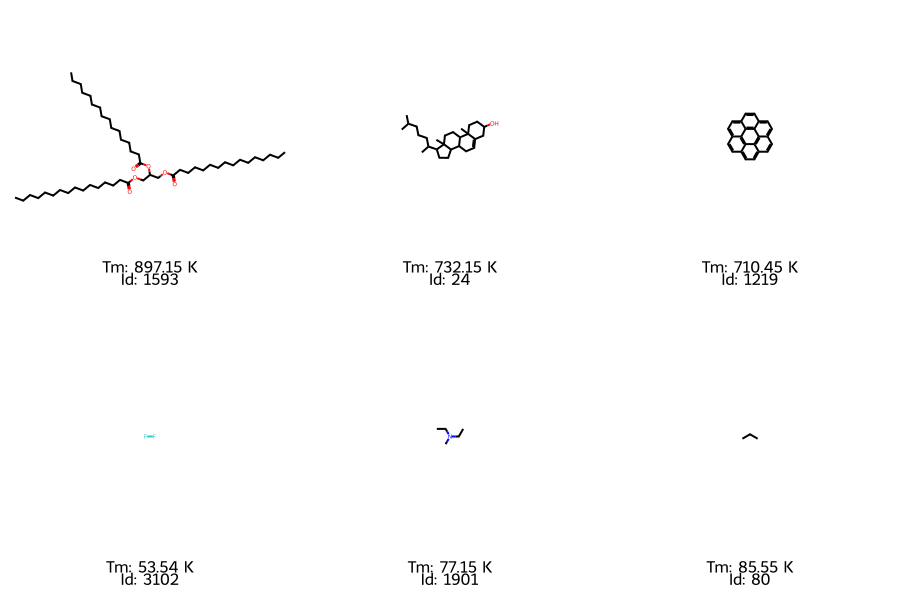

In [11]:
from rdkit.Chem import Draw

top_high_tm = df_train.nlargest(3, 'Tm')
top_low_tm = df_train.nsmallest(3, 'Tm')
extremes = pd.concat([top_high_tm, top_low_tm])

mols = [Chem.MolFromSmiles(s) for s in extremes['SMILES']]
legends = [f"Tm: {tm} K\nId: {i}" for tm, i in zip(extremes['Tm'], extremes['id'])]

img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300, 300), 
                           legends=legends, returnPNG=False)

display(img)

Nhóm $T_m$ Cao (Hàng trên): Quan sát xem chúng có đặc điểm gì chung? Thường bạn sẽ thấy:
-Nhiều vòng thơm (benzene, naphthalene...) nối với nhau (hệ thống phẳng, xếp chồng tốt).
-Chứa các nhóm phân cực mạnh như Axit (-COOH), Amide (-CONH-) tạo liên kết Hydro.
-Cấu trúc đối xứng cao.

Nhóm $T_m$ Thấp (Hàng dưới):
-Mạch thẳng dài, nhiều nhánh (gây cản trở không gian).
-Ít nhóm chức phân cực.
-Chứa các liên kết Ether (-O-) hoặc Ester (-COO-) làm giảm độ bền mạng tinh thể.

Tổng hợp: Đây là bằng chứng trực quan nhất để khẳng định rằng: Cấu trúc quyết định tính chất.